### Détails des étapes :
1. **Critères et création des points d'objet** :
   - Les critères définissent quand l'algorithme de détection des coins s'arrête.
   - `objp` représente les points d'un échiquier dans le monde réel, avec z=0.

2. **Détection des coins dans les images** :
   - Conversion des images en niveaux de gris pour faciliter la détection des coins.
   - Détection des coins pour chaque image et stockage des points 2D/3D.

3. **Calibration de la caméra** :
   - Calcul des matrices intrinsèques (`mtx`) et des vecteurs de rotation/translation (`rvecs`, `tvecs`).

4. **Calcul des matrices de rotation et translation** :
   - Les vecteurs de rotation sont convertis en matrices.
   - Les matrices de rotation sont étendues avec les vecteurs de translation pour former des matrices 3x4.

5. **Projection et position des caméras** :
   - Les matrices de projection (3x4) combinent les paramètres intrinsèques et extrinsèques.
   - Les centres des caméras sont calculés dans le référentiel monde via des coordonnées homogènes.

Ce format garde le code clair et précise chaque étape clé sans surcharger d'informations inutiles.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob

# Critères d'arrêt pour l'algorithme de détection des coins de l'échiquier
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Création des points d'objet 3D pour un échiquier de 7x7 intersections
objp = np.zeros((7*7, 3), np.float32)  # Initialisation d'un tableau de points (z=0 par défaut)
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)  # Coordonnées x, y de la grille d'intersections

# print(objp)

# Listes pour stocker les points 3D (réels) et les points 2D (dans l'image)
objpoints = []  # Points 3D
imgpoints = []  # Points 2D

# Parcours des images d'échiquier correspondantes
for fname in glob.glob('chessboards/c4*.png'):
    img = cv.imread(fname)  # Chargement de l'image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Conversion de l'image en niveaux de gris
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None)  # Détection des coins de l'échiquier
    if ret:
        objpoints.append(objp)  # Ajout des points 3D correspondants
        imgpoints.append(corners)  # Ajout des coins détectés (points 2D)

# Calibration de la caméra avec les points correspondants 2D et 3D
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# ret : Booléen indiquant si la calibration a réussi
# mtx : Matrice intrinsèque de la caméra
# dist : Coefficients de distorsion (non utilisés ici)
# rvecs, tvecs : Vecteurs de rotation et translation pour chaque image

# Conversion des vecteurs de rotation en matrices de rotation
rmatRight = cv.Rodrigues(rvecs[0])[0]  # Matrice de rotation pour la caméra droite
rmatLeft = cv.Rodrigues(rvecs[1])[0]   # Matrice de rotation pour la caméra gauche

# Ajout des vecteurs de translation pour obtenir des matrices 3x4
rotMatRight = np.concatenate((rmatRight, tvecs[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft, tvecs[1]), axis=1)

# Matrices de projection des caméras (intrinsèque * rotation-translation)
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

# Calcul des centres des caméras dans le référentiel monde (coordonnées homogènes 4x1)
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])


### Détails :
1. **Introduction de la fonction** : Explique son rôle global (visualisation de la position des caméras et des points 3D).
2. **Étapes principales** :
   - Création de la figure 3D et des axes.
   - Affichage des points de l'objet 3D.
   - Affichage des positions des caméras gauche et droite avec des couleurs distinctes.
3. **Appel de la fonction** : Indique que la scène est générée lorsqu'on appelle `plotDotWorld`.

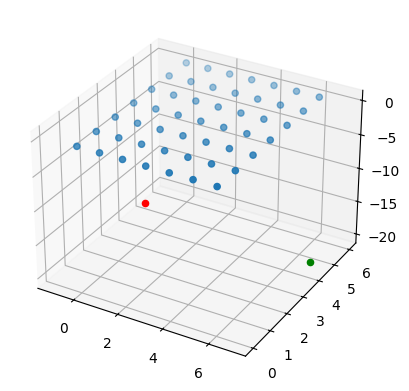

In [35]:
# Fonction pour visualiser dans l'espace 3D la position des caméras et de l'objet (jeu d'échecs)
def plotDotWorld():
    # Création d'une figure 3D
    fig = plt.figure()                                       # Crée une figure vide
    ax = plt.axes(projection='3d')                          # Ajoute des axes 3D pour une visualisation en trois dimensions
    
    # Affichage des points 3D de l'objet
    ax.scatter3D(objp[:, 0], objp[:, 1], objp[:, 2])         # Place les points de l'objet (objp) dans l'espace 3D
    
    # Affichage de la position de la caméra gauche
    x, y, z, d = camWorldCenterLeft                          # Coordonnées homogènes de la caméra gauche
    ax.scatter(x, y, z, c='g', marker='o')                   # Représente la caméra gauche par un point vert ('g')
    
    # Affichage de la position de la caméra droite
    x2, y2, z2, d2 = camWorldCenterRight                     # Coordonnées homogènes de la caméra droite
    ax.scatter(x2, y2, z2, c='r', marker='o')                # Représente la caméra droite par un point rouge ('r')
    
    # Affichage de la figure 3D
    plt.show()                                               # Affiche la figure

# Appel de la fonction pour afficher la scène 3D
plotDotWorld()


mask


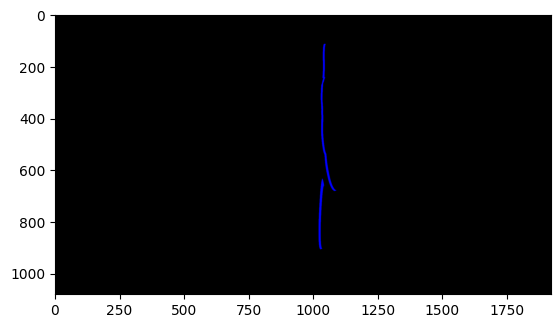

In [36]:
# Affiche le résultat de la fonction getImgLine(fname) pour une image donnée

# Chargement de l'image
img = cv.imread("scanRight/scan0011.png")  # Charge l'image spécifiée dans une variable

# Application d'un seuillage pour isoler les éléments souhaités
ret, mask = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)  
# Seuil fixé à 127 : les pixels ayant une intensité inférieure à ce seuil sont mis à zéro
# Méthode THRESH_TOZERO : conserve les pixels supérieurs au seuil sans modification

# Affichage du masque obtenu
print("mask")         # Indique dans la console que l'image affichée est le masque
plt.imshow(mask)      # Affiche l'image transformée sous forme de masque


### Détails :
1. **Structure générale** : 
   - Explique les fonctions de manière claire et leur rôle dans le contexte (e.g., calcul de matrice fondamentale, extraction de lignes rouges, etc.).

2. **Détails spécifiques** :
   - `crossMat(v)` : Calcul de la matrice croisée pour un vecteur.
   - `matFondamental` : Décrit étape par étape le calcul de la matrice fondamentale.
   - `getImgLine` : Simplifie une image en isolant la ligne rouge.

3. **Boucle principale dans `findEpilines`** :
   - Décompose la logique : formatage des fichiers, extraction de la ligne, calcul des points homogènes, et utilisation de la matrice fondamentale.

4. **Finalité** :
   - Clarifie le rôle des variables globales comme `Fondamental` et le format final des données (liste des épilignes et points).

Avec ces commentaires, le code est plus facile à suivre tout en restant concis et directement lié à son objectif.

In [37]:
# Fonction pour calculer la matrice de produit vectoriel (matrice croisée) d'un vecteur
def crossMat(v):
    # Extrait les composantes du vecteur (assume v sous forme [[x], [y], [z]])
    v = v[:, 0]  
    # Retourne la matrice croisée de v
    return np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]], 
                     [-v[1], v[0], 0]])

# Fonction pour calculer la matrice fondamentale entre deux caméras
def matFondamental(camLeft, centerRight, camRight):
    # Pseudo-inverse de la matrice de la caméra droite, multipliée par la gauche
    # Multiplie ensuite par le produit matriciel des coordonnées homogènes (camLeft @ centerRight)
    # Utilise le produit vectoriel via crossMat pour finaliser le calcul
    return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))

# Fonction pour isoler la ligne rouge d'une image donnée
def getImgLine(fname):              
    img = cv.imread(fname)                                      # Charge l'image spécifiée
    red = img[:, :, 2]                                          # Extrait le canal rouge (évite erreurs dans epilines)
    ret, mask = cv.threshold(red, 127, 255, cv.THRESH_TOZERO)   # Conserve uniquement les pixels rouges au-dessus du seuil
    return mask                                                 # Retourne une image masque

# Fonction pour trouver les épilignes à partir des images
def findEpilines(path):
    epilines = []                                               # Liste pour stocker les épilignes
    for l in range(26):                                         # Parcourt les 26 images
        # Formate le nom de fichier avec le bon nombre de zéros
        strp = path + ('000' if l < 10 else '00') + str(l) + '.png'
        
        # Obtenez l'image masque avec uniquement la ligne
        ImgLine = getImgLine(strp)
        pointsLeft = [[], [], []]                               # Points homogènes pour l'image gauche

        for index, line in enumerate(ImgLine):                 # Parcourt chaque ligne de pixels de l'image
            for pixel in line:                                  # Parcourt chaque pixel de la ligne
                if pixel != 0:                                  # Si le pixel est non nul (fait partie de la ligne rouge)
                    pixel = 1                                   # Normalise la valeur du pixel à 1
            
            try:
                # Calcul des coordonnées moyennes pondérées par la valeur des pixels
                pointsLeft[0].append(np.average(range(1920), weights=line))  # Moyenne pondérée pour x
                pointsLeft[1].append(index)                                  # Coordonnée y (index de la ligne)
                pointsLeft[2].append(1)                                      # Coordonnées homogènes
            except:
                pass  # Ignorer les exceptions si aucune ligne valide n'est trouvée
            
        # Calcul des épilignes pour l'image droite avec la matrice fondamentale
        epilinesRight = Fondamental @ pointsLeft  
        epilines.append([pointsLeft, epilinesRight])  # Ajoute les points et leurs épilignes correspondants
    return epilines

# Calcul de la matrice fondamentale entre les deux caméras
Fondamental = matFondamental(camRight, camWorldCenterLeft, camLeft)

# Calcul des épilignes pour les images du dossier 'scanLeft/'
epl = findEpilines('scanLeft/')  # Format final : [[pointsLeft], [epilinesRight]]


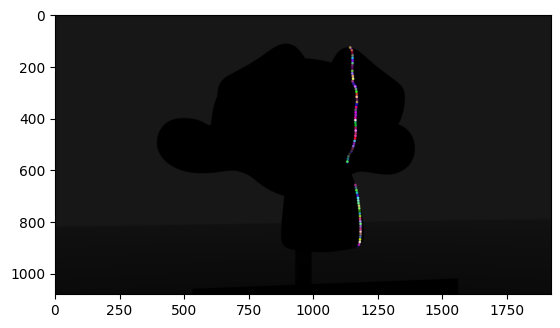

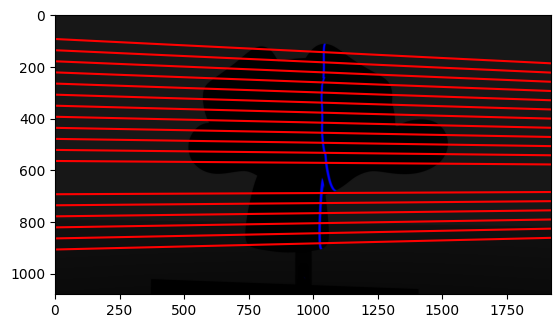

In [38]:
def drawAvgPoint(fname,EplLeft):                                                    # Cette fonction affiche les points de la ligne laser, input le nom de l'img et les pointsLeft de l'img
    img = cv.imread(fname)                                                          # 
    i = 0
    while i< len(EplLeft[0]):                                                       # Tant qu'il y a des "avg" qui n'ont pas été couverts
        color = tuple(np.random.randint(0,255,3).tolist())                          #
        img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)     #
        i += 10                                                                     #
    plt.imshow(img)                                                                 # On affiche l'image modifiée
    plt.show()      


def lineY(coef,x):
    a,b,c = coef
    return-(c+a*x)/b


def drawEpl(fname,EplRight):
    img = cv.imread(fname)
    coef , length = EplRight.shape
    for i in range(0,length,40):
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'r')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0011.png',epl[11][0])
drawEpl('scanRight/scan0011.png',epl[11][1])
